Continuous waveform mode
========================

In this tutorial we will demonstrate continuous waveform mode (see [Continuous waveform mode](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#continuous-waveform-mode)).
In addition, we will observe the output on an oscilloscope to demonstrate the results.

This tutorial is designed with the Pulsar QCM in mind, but can easily be used with a Pulsar QRM as well. Change any Pulsar QCM reference to
Pulsar QRM and only use one sequencer.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import pprint
import os
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from pulsar_qcm.pulsar_qcm import pulsar_qcm

#Close any existing connections to any pulsar_qcm
pulsar_qcm.close_all()

#Connect to the Pulsar QCM at default IP address.
pulsar = pulsar_qcm("qcm", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_status())

Status:
{'status': 'OKAY', 'flags': []}


Generate waveforms
------------------

Next, we are going to generate a couple of waveforms that we are going to upload to the instrument in the next step.

In [2]:
#Waveform parameters
waveform_length = 120 #nanoseconds (needs to be a multiple of 4 ns)
    
#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
                "gaussian": {"data": [], "index": 0},
                "sine":     {"data": [], "index": 1},
                "sawtooth": {"data": [], "index": 2},
                "dc":       {"data": [], "index": 3}
            }

#Create gaussian waveform
if "gaussian" in waveforms:
    waveforms["gaussian"]["data"] = scipy.signal.gaussian(waveform_length, std=0.12 * waveform_length)

#Create sine waveform
if "sine" in waveforms:
    waveforms["sine"]["data"] = [math.sin((2 * math.pi / (0.5 * waveform_length)) * i ) for i in range(0, waveform_length//2)]

#Create sawtooth waveform
if "sawtooth" in waveforms:
    waveforms["sawtooth"]["data"] = [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)]

#Create DC waveform
if "dc" in waveforms:
     waveforms["dc"]["data"] = [1.0 for i in range(0, 4)] #DC only needs to 4 samples and can be repeated

Let's plot the waveforms to see what we have created.

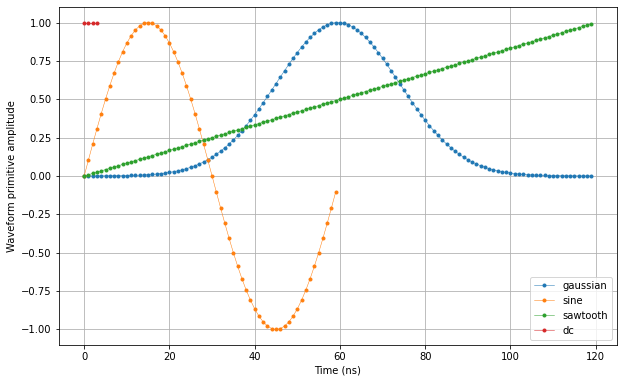

In [3]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()

matplotlib.pyplot.draw()
matplotlib.pyplot.show()   # add this at EOF to prevent execution stall

Upload waveforms
----------------

Now that we know that the waveforms are what we expect them to be, let's upload them to the instrument.
To do this we need to store the waveforms in a JSON file together with a Q1ASM program for the sequence
processor. Since we are going to use continuous waveform mode, the sequence processor will be bypassed 
and the Q1ASM program can be trivial (i.e. `stop`).

In [4]:
#Sequence program.
seq_prog = "stop"

#Reformat waveforms to lists if necessary.
for name in waveforms:
    if str(type(waveforms[name]["data"]).__name__) == "ndarray":
        waveforms[name]["data"] = waveforms[name]["data"].tolist()  # JSON only supports lists
    assert (len(waveforms[name]["data"]) % 4) == 0, "In continuous waveform mode the lenght of a waveform must be a multiple of 4!"

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms, "weights": {}, "acquisitions": {}, "program": seq_prog}
with open("cont_wave_mode.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [5]:
#Upload waveforms and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "cont_wave_mode.json"))
pulsar.sequencer1_waveforms_and_program(os.path.join(os.getcwd(), "cont_wave_mode.json"))

Play waveforms
--------------

The waveforms have been uploaded to the instrument. Now we need to configure the instrument to run in continuous waveform mode. We
do this by setting the following parameters of the sequencers.

In [6]:
#Configure the sequencers to run in continuous waveform mode.
for sequencer in range(0, 2):
    pulsar.set("sequencer{}_cont_mode_en_awg_path0".format(sequencer), True)
    pulsar.set("sequencer{}_cont_mode_en_awg_path1".format(sequencer), True)

#Map sequencers to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 4):
        pulsar.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar.sequencer0_channel_map_path0_out0_en(True)
pulsar.sequencer0_channel_map_path1_out1_en(True)
pulsar.sequencer1_channel_map_path0_out2_en(True)
pulsar.sequencer1_channel_map_path1_out3_en(True)

#Set specific waveform to specific output.
pulsar.sequencer0_cont_mode_waveform_idx_awg_path0(0) #Gaussian on O1
pulsar.sequencer0_cont_mode_waveform_idx_awg_path1(1) #Sine on O2
pulsar.sequencer1_cont_mode_waveform_idx_awg_path0(2) #Sawtooth on 03
pulsar.sequencer1_cont_mode_waveform_idx_awg_path1(3) #DC on O4

Now let's start playback.

In [7]:
#Arm and start both sequencers.
pulsar.arm_sequencer(0)
pulsar.arm_sequencer(1)
pulsar.start_sequencer()

#Print status of both sequencers (should now say Q1 stopped, because of the stop instruction).
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))

Status:
{'status': 'STOPPED', 'flags': []}
{'status': 'STOPPED', 'flags': []}


Check waveforms
---------------

The instrument is now running in continuous waveform mode. Now let's connect an oscilloscope and check the outputs.
We connect all output channels of the Pulsar QCM to four channels of an oscilloscope.
On the scope we are able to see that all waveforms are being generated correctly:

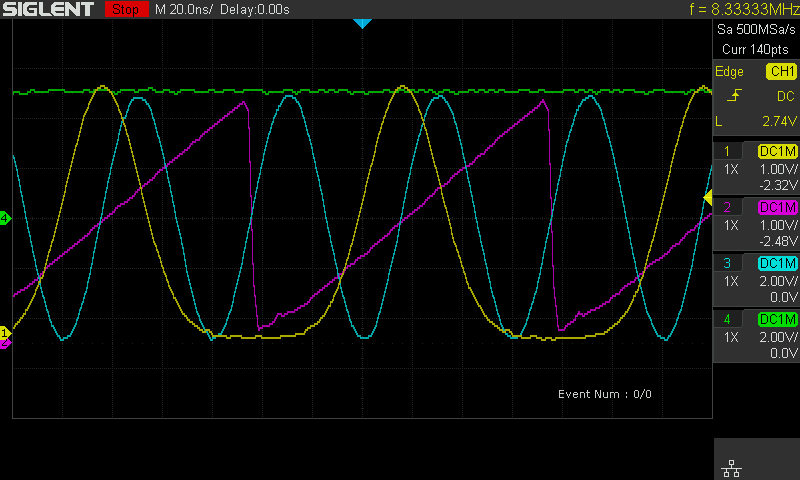

Outputs: Yellow=$\text{O}^{1}$, Blue=$\text{O}^{2}$, Purple=$\text{O}^{3}$ and Green=$\text{O}^{4}$

Stop
----

Finally, let's stop the playback and close the instrument connection.

In [8]:
#Stop both sequencers.
pulsar.stop_sequencer()
    
#Print status of both sequencers (should now say it is stopped).
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Status:
{'status': 'STOPPED', 'flags': ['FORCED STOP']}
{'status': 'STOPPED', 'flags': ['FORCED STOP']}

Snapshot:
qcm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
out0_offset                                 :	0 (V)
out1_offset                                 :	0 (V)
out2_offset                                 :	0 (V)
out3_offset                                 :	0 (V)
reference_source                            :	internal 
sequencer0_channel_map_path0_out0_en        :	True 
sequencer0_channel_map_path0_out2_en        :	False 
sequencer0_channel_map_path1_out1_en        :	True 
sequencer0_channel_map_path1_out3_en        :	False 
sequencer0_cont_mode_en_awg_path0           :	True 
sequencer0_cont_mode_en_awg_path1           :	True 
sequencer0_cont_mode_waveform_idx_awg_path0 :	0 
sequencer0_cont_mode_waveform_idx_awg_pat